# Playing around with Quasars

In [1]:
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.table import Table
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import vstack

import collections
import numpy as np
import healpy as hp


In [2]:
def bin_z(field, bins_top_bounds):
    ordered_field = field.sort_values(by=['Z'])      #Sort the pandas frame by z
    z = ordered_field['Z'].values                    #get redshifts
    bin_indecis = np.digitize(z, bins_top_bounds, True)         #Assing each entry in z a bin
                                                                #Lower bound close, upper open
        
    bin_count = np.bincount(bin_indecis)             #Counts items in each bin
    print('elements per bin', bin_count)
    binned_data = np.split(ordered_field, np.cumsum(bin_count)) 
                                                     #np.cumsum tells us at which element the bin ends 
                                                     #then split accordingly
            
                                                     #method creates an empty fourth bin, just remove it
    return binned_data[:-1]
        
    

In [3]:
def make_map(field, random):
    nside = 512
    
    field_ra = np.radians(field['RA'].values) #Phi
    field_dec = np.radians(field['DEC'].values) #Pi/2 - dec = theta
    random_ra = np.radians(random['RA'].values) 
    random_dec = np.radians(random['DEC'].values) 
    
    field_FKP = np.array(field['WEIGHT_FKP'].values) 
    field_SYSTOT = np.array(field['WEIGHT_SYSTOT'].values) 
    field_CP = np.array(field['WEIGHT_CP'].values) 
    field_NOZ = np.array(field['WEIGHT_NOZ'].values)
    field_data = field_SYSTOT*field_CP*field_NOZ #FKP left out
    
    random_FKP = np.array(random['WEIGHT_FKP'].values) 
    random_SYSTOT = np.array(random['WEIGHT_SYSTOT'].values) 
    random_CP = np.array(random['WEIGHT_CP'].values) 
    random_NOZ = np.array(random['WEIGHT_NOZ'].values)
    random_data = random_SYSTOT*random_CP*random_NOZ
    
    field_indices = hp.ang2pix(nside, np.pi/2 - field_dec, field_ra) #pixel_indecis
    random_indices = hp.ang2pix(nside, np.pi/2 - random_dec, random_ra)  
    
    field_pixel_data = np.bincount(field_indices, field_data, hp.nside2npix(nside)) 
                                                                        #for each pixel in the resolution, 
                                                                        #Adds all the data entries that 
                                                                        #have been assigned the such pixel
    random_pixel_data = np.bincount(random_indices, random_data, hp.nside2npix(nside))
    
    alpha = sum(field_pixel_data)/sum(random_pixel_data)
    
    pixel_density_data = np.zeros(hp.nside2npix(nside))
    goodpix = random_pixel_data > 0   #avoid dividing by 0
    pixel_density_data[goodpix] = field_pixel_data[goodpix] / alpha*random_pixel_data[goodpix] - 1
    
    return pixel_density_data
    
   

Load the data

In [4]:
#NGC =  fits.open('/mnt/zfsusers/jaimerz/data/eBOSS_QSO_clustering_data-NGC-vDR16.fits')
#NGC_r =  fits.open('/mnt/zfsusers/jaimerz/data/eBOSS_QSO_clustering_random-NGC-vDR16.fits')
#SGC =  fits.open('/mnt/zfsusers/jaimerz/data/eBOSS_QSO_clustering_data-SGC-vDR16.fits')
#SGC_r =  fits.open('/mnt/zfsusers/jaimerz/data/eBOSS_QSO_clustering_random-SGC-vDR16.fits')
NGC =  fits.open('/home/zcapjru/PhD/Data/eBOSS_QSO_clustering_data-NGC-vDR16.fits')
NGC_r =  fits.open('/home/zcapjru/PhD/Data/eBOSS_QSO_clustering_random-NGC-vDR16.fits')
SGC =  fits.open('/home/zcapjru/PhD/Data/eBOSS_QSO_clustering_data-SGC-vDR16.fits')
SGC_r =  fits.open('/home/zcapjru/PhD/Data/eBOSS_QSO_clustering_random-SGC-vDR16.fits')



Information about data

In [5]:
cols = NGC_r[1].columns
cols.info()

name:
    ['RA', 'DEC', 'Z', 'WEIGHT_FKP', 'WEIGHT_SYSTOT', 'WEIGHT_CP', 'WEIGHT_NOZ', 'NZ']
format:
    ['D', 'D', 'D', 'D', 'D', 'D', 'D', 'D']
unit:
    ['', '', '', '', '', '', '', '']
null:
    ['', '', '', '', '', '', '', '']
bscale:
    ['', '', '', '', '', '', '', '']
bzero:
    ['', '', '', '', '', '', '', '']
disp:
    ['', '', '', '', '', '', '', '']
start:
    ['', '', '', '', '', '', '', '']
dim:
    ['', '', '', '', '', '', '', '']
coord_type:
    ['', '', '', '', '', '', '', '']
coord_unit:
    ['', '', '', '', '', '', '', '']
coord_ref_point:
    ['', '', '', '', '', '', '', '']
coord_ref_value:
    ['', '', '', '', '', '', '', '']
coord_inc:
    ['', '', '', '', '', '', '', '']
time_ref_pos:
    ['', '', '', '', '', '', '', '']


From fits to pandas and then to maps

In [6]:
NGC_table =   Table.read(NGC)
NGC_r_table =  Table.read(NGC_r)
SGC_table =   Table.read(SGC)
SGC_r_table = Table.read(SGC_r)

In [7]:
NGC_data = NGC_table.to_pandas()
NGC_r_data = NGC_r_table.to_pandas()
SGC_data = SGC_table.to_pandas()
SGC_r_data = SGC_r_table.to_pandas()

bin data

In [8]:
binned_NGC   = bin_z(NGC_data, [1.5])
binned_NGC_r = bin_z(NGC_r_data, [1.5])
binned_SGC   = bin_z(SGC_data, [1.5])
binned_SGC_r = bin_z(SGC_r_data, [1.5])

elements per bin [107527 110682]
elements per bin [5470462 5629396]
elements per bin [60740 64759]
elements per bin [3469920 3699881]


Thread and map

In [9]:
NGC_maps = []
for i in range(len(binned_NGC)):
    NGC_maps.append(make_map(binned_NGC[i],binned_NGC_r[i] ))
    
SGC_maps = []
for i in range(len(binned_SGC)):
    SGC_maps.append(make_map(binned_SGC[i],binned_SGC_r[i] ))

Plot

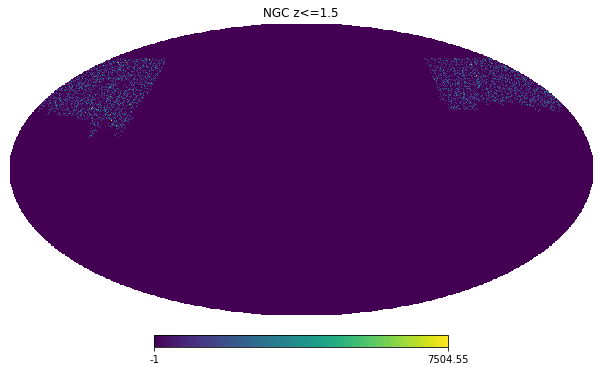

In [10]:
hp.visufunc.mollview(NGC_maps[0], title= 'NGC z<=1.5')

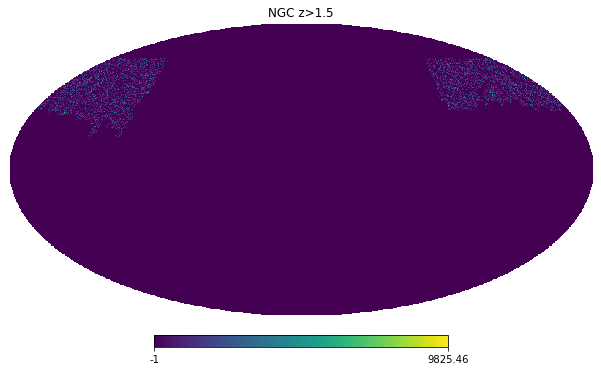

In [11]:
hp.visufunc.mollview(NGC_maps[1],title= 'NGC z>1.5')

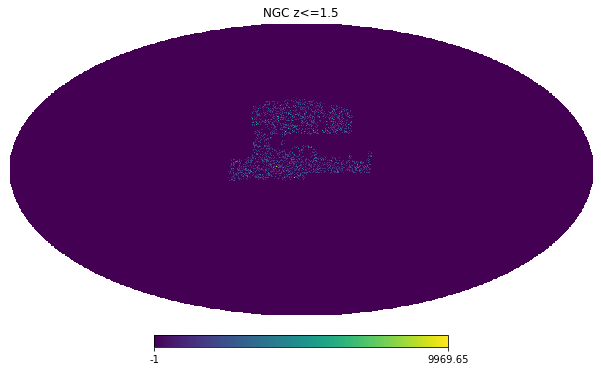

In [12]:
hp.visufunc.mollview(SGC_maps[0], title= 'NGC z<=1.5')

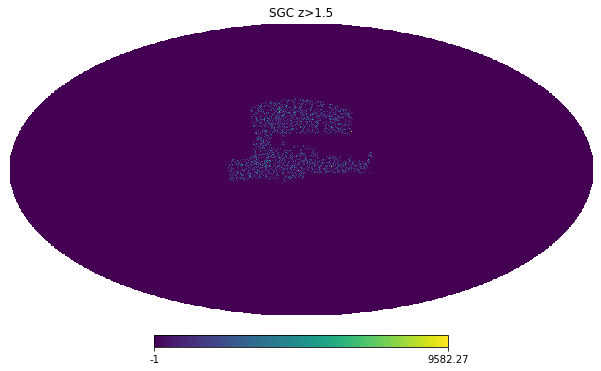

In [13]:
hp.visufunc.mollview(SGC_maps[1], title= 'SGC z>1.5')